# Titanic Dataset – Handling Missing Values

## Objective
This notebook explores multiple strategies for handling missing values in the Titanic dataset and compares their impact on model performance.  
The goal is to evaluate different imputation techniques in a consistent modeling setup.

---

## 1. Setup
- **Create** a `processed/` folder to store processed datasets.
- **Load** `train.csv` from the Titanic dataset.

---

## 2. Missingness Exploration
We begin by understanding where and how much data is missing:
- Missing value counts and percentages
- Heatmap of missingness using `missingno.matrix()`
- Bar plot showing missingness per feature

---

## 3. Techniques Implemented

Each technique:
1. Applies a specific missing value handling strategy  
2. Saves the processed dataset in `processed/`  
3. Trains a Logistic Regression model  
4. Records accuracy in a results list  

**Techniques:**

| Code | Technique | Description |
|------|-----------|-------------|
| **T1** | Drop rows with missing values | Removes any row containing at least one NaN |
| **T2** | Drop columns with >70% missing | Removes entire columns where over 70% of entries are NaN |
| **T3** | Fill with constant | Uses `"Unknown"` for categorical, `0` for numeric features |
| **T4** | Mean (numeric) + Mode (categorical) | Replaces NaNs with column mean (numeric) or most frequent value (categorical) |
| **T5** | Median (numeric) + Mode (categorical) | Similar to T4 but uses median for numeric features |
| **T6** | KNN Imputation | Finds nearest neighbors to estimate missing values |
| **T7** | Iterative Imputation (MICE) | Models each feature with NaNs as a function of the others, iteratively imputing |
| **T8** | Domain-based Deck Extraction | From the `Cabin` column, extracts deck letter; imputes missing with "Unknown" |
| **T9** | Add Missingness Indicators | Creates binary flags for whether a value was originally missing, then imputes |

---

## 4. Model Evaluation
- Same train/test split for all methods for fairness  
- Metric: `accuracy_score` from Logistic Regression  
- Results stored in a summary DataFrame

---

## 5. Save Summary
Results saved to `titanic_imputation_summary.csv` with:
- Technique name
- Accuracy
- Processing notes

---

## 6. Visual Comparison
- Bar chart comparing accuracy for all techniques  
- Table showing missing value counts before and after imputation


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Titanic – Missing Value Handling Techniques


In [8]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # <-- add this line
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder






# ----------------------------
# 1. Setup
# ----------------------------

In [9]:

os.makedirs("processed", exist_ok=True)

# Load Titanic dataset (train.csv from Kaggle)
df_original = pd.read_csv("/content/drive/MyDrive/0.Latest_DS_Course/Statistics/Descriptive/8.EDA/data/titanic.csv")
df = df_original.copy()

print("Initial shape:", df.shape)
display(df.head())

Initial shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB



# ----------------------------
# 2. Missingness Exploration
# ----------------------------

In [11]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [12]:

missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100
print("\nMissing Value Counts:\n", missing_counts[missing_counts > 0])




Missing Value Counts:
 Age         177
Cabin       687
Embarked      2
dtype: int64


In [13]:
missing_pct

,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.865320
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


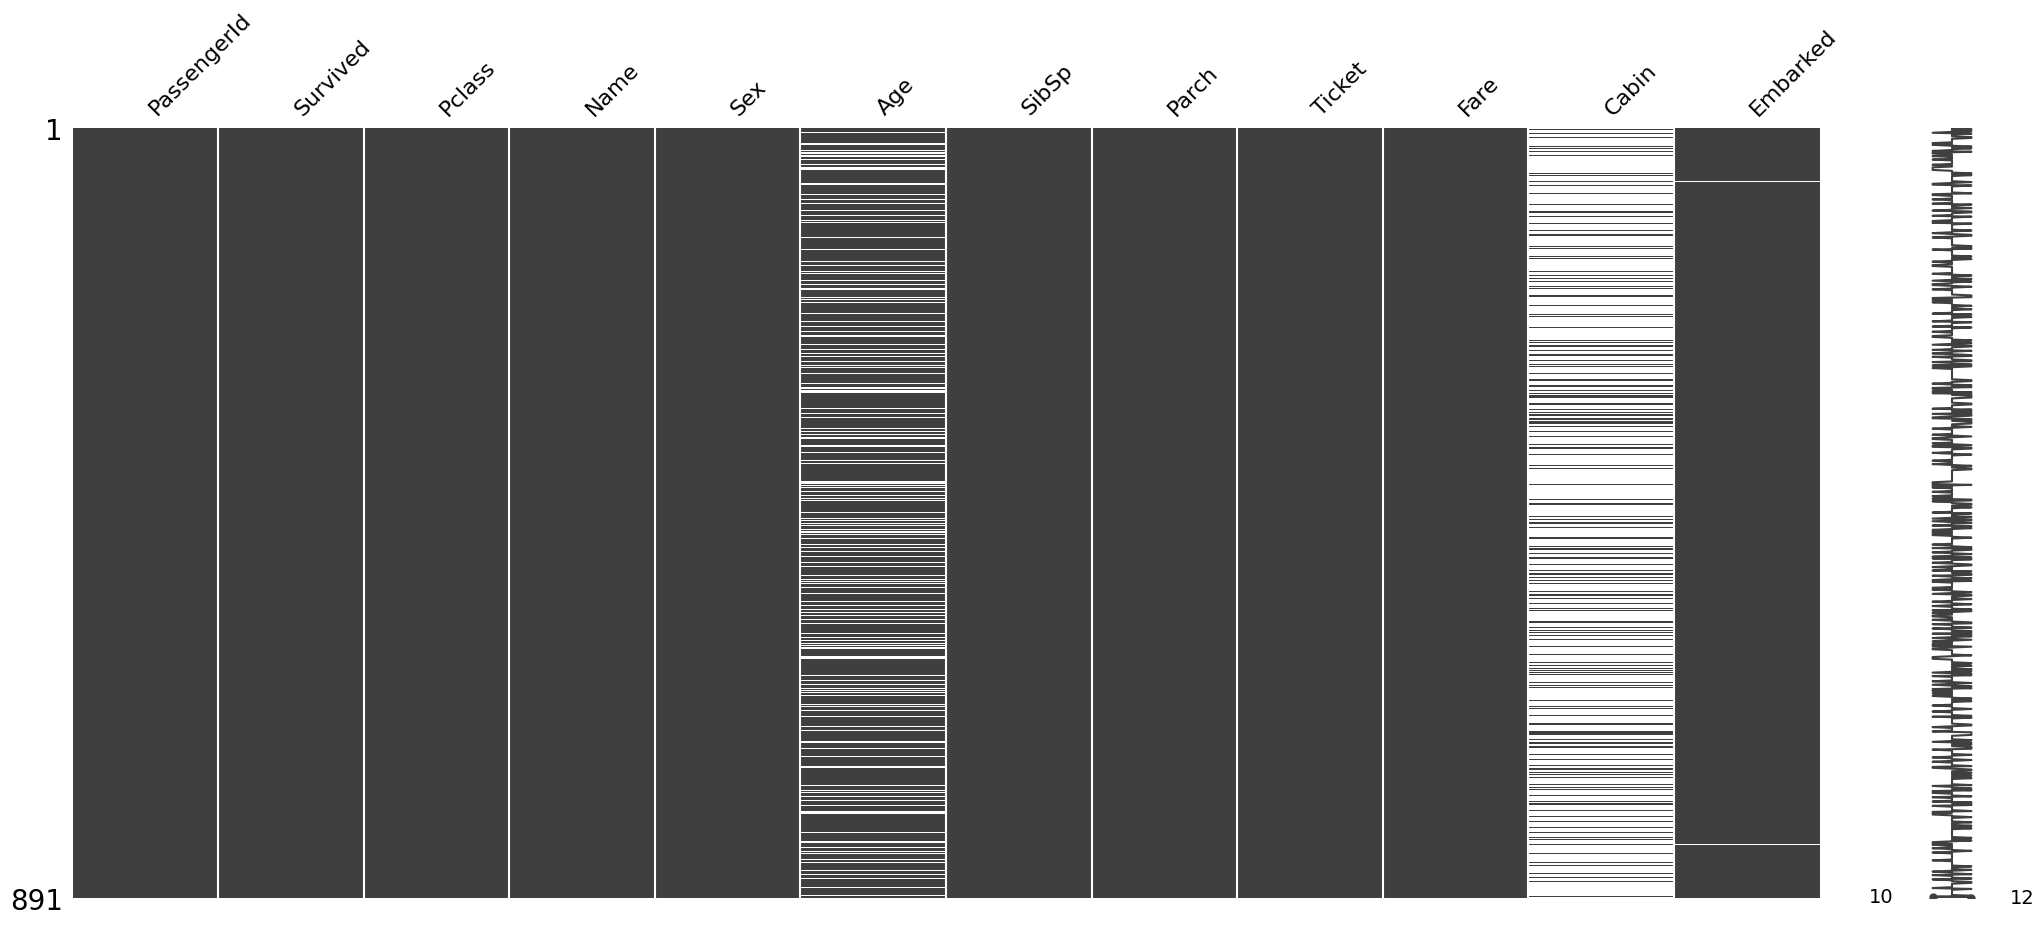

In [14]:
# Visual missingness
msno.matrix(df)
plt.show()


# ----------------------------
# Utility Functions
# ----------------------------

In [15]:

def encode_categoricals(df):
    """Encode categorical columns for modeling."""
    df_copy = df.copy()
    for col in df_copy.select_dtypes(include=['object']).columns:
        df_copy[col] = df_copy[col].fillna("Unknown")
        df_copy[col] = LabelEncoder().fit_transform(df_copy[col])
    return df_copy


def evaluate_and_save(df_filled, name, notes):
    """Save processed dataset, handle residual NaNs, train model with scaling, return accuracy."""
    file_path = f"processed/titanic_{name}.csv"
    df_filled.to_csv(file_path, index=False)

    # Prepare for modeling
    df_encoded = encode_categoricals(df_filled)

    # Handle any remaining NaNs (fill with median for numeric, mode for categorical)
    for col in df_encoded.columns:
        if df_encoded[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_encoded[col]):
                df_encoded[col] = df_encoded[col].fillna(df_encoded[col].median())
            else:
                df_encoded[col] = df_encoded[col].fillna(df_encoded[col].mode()[0])

    X = df_encoded.drop(columns=["Survived"])
    y = df_encoded["Survived"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)
    acc = accuracy_score(y_test, model.predict(X_test_scaled))

    return {"Technique": name, "Accuracy": acc, "Notes": notes}


results = []


# ----------------------------
# 3. Techniques
# ----------------------------


# T1 – Drop rows with missing values


In [16]:

df_drop_rows = df.dropna()
results.append(evaluate_and_save(df_drop_rows, "drop_rows", "Dropped all rows with missing values"))


In [32]:
df.shape, df_drop_rows.shape

((891, 12), (183, 12))

In [17]:
results

[{'Technique': 'drop_rows',
  'Accuracy': 0.7297297297297297,
  'Notes': 'Dropped all rows with missing values'}]

# T2 – Drop columns with >70% missing


In [33]:
df.isnull().mean()

,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.198653
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


In [18]:
# dropping cols that have more than 70% rows with missing values
threshold = 0.7
df_drop_cols = df.drop(columns=df.columns[df.isnull().mean() > threshold])
results.append(evaluate_and_save(df_drop_cols, "drop_cols", "Dropped columns with >70% missing values"))


In [19]:
results

[{'Technique': 'drop_rows',
  'Accuracy': 0.7297297297297297,
  'Notes': 'Dropped all rows with missing values'},
 {'Technique': 'drop_cols',
  'Accuracy': 0.8156424581005587,
  'Notes': 'Dropped columns with >70% missing values'}]

# T3 – Fill with constants


In [20]:

df_const = df.copy()
for col in df_const.columns:
    if df_const[col].dtype == "object":  # if its str replace nan with unknown else fill 0
        df_const[col] = df_const[col].fillna("Unknown")
    else:
        df_const[col] = df_const[col].fillna(0)
results.append(evaluate_and_save(df_const, "constant_fill", "Filled with 0 for numeric, 'Unknown' for categorical"))


In [21]:
results

[{'Technique': 'drop_rows',
  'Accuracy': 0.7297297297297297,
  'Notes': 'Dropped all rows with missing values'},
 {'Technique': 'drop_cols',
  'Accuracy': 0.8156424581005587,
  'Notes': 'Dropped columns with >70% missing values'},
 {'Technique': 'constant_fill',
  'Accuracy': 0.8100558659217877,
  'Notes': "Filled with 0 for numeric, 'Unknown' for categorical"}]

# T4 – Mean for numeric, Mode for categorical


In [22]:

df_mean_mode = df.copy()
for col in df_mean_mode.columns:
    if df_mean_mode[col].dtype != "object": # fill with mode if object else mean
        df_mean_mode[col] = df_mean_mode[col].fillna(df_mean_mode[col].mean())
    else:
        df_mean_mode[col] = df_mean_mode[col].fillna(df_mean_mode[col].mode()[0])
results.append(evaluate_and_save(df_mean_mode, "mean_mode", "Mean numeric, mode categorical"))


# T5 – Median for numeric, Mode for categorical


In [23]:

df_median_mode = df.copy()
for col in df_median_mode.columns:
    if df_median_mode[col].dtype != "object":
        df_median_mode[col] = df_median_mode[col].fillna(df_median_mode[col].median())
    else:
        df_median_mode[col] = df_median_mode[col].fillna(df_median_mode[col].mode()[0])
results.append(evaluate_and_save(df_median_mode, "median_mode", "Median numeric, mode categorical"))


# T6 – KNN Imputation


In [24]:

df_knn = df.copy()
df_knn_enc = encode_categoricals(df_knn)
df_knn_enc

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,108,1,22.0,1,0,523,7.2500,147,2
1,2,1,1,190,0,38.0,1,0,596,71.2833,81,0
2,3,1,3,353,0,26.0,0,0,669,7.9250,147,2
3,4,1,1,272,0,35.0,1,0,49,53.1000,55,2
4,5,0,3,15,1,35.0,0,0,472,8.0500,147,2
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,548,1,27.0,0,0,101,13.0000,147,2
887,888,1,1,303,0,19.0,0,0,14,30.0000,30,2
888,889,0,3,413,0,NaN,1,2,675,23.4500,147,2
889,890,1,1,81,1,26.0,0,0,8,30.0000,60,0


In [25]:
imputer_knn = KNNImputer(n_neighbors=5)
df_knn_filled = pd.DataFrame(imputer_knn.fit_transform(df_knn_enc), columns=df_knn_enc.columns)
results.append(evaluate_and_save(df_knn_filled, "knn", "KNNImputer with k=5"))


In [36]:
df_knn_filled.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


# T7 – Iterative Imputation (MICE - Multivariate imputation by chained equation)


In [26]:

df_iter = df.copy()
df_iter_enc = encode_categoricals(df_iter)
imputer_iter = IterativeImputer(random_state=42, max_iter=10)
df_iter_filled = pd.DataFrame(imputer_iter.fit_transform(df_iter_enc), columns=df_iter_enc.columns)
results.append(evaluate_and_save(df_iter_filled, "iterative", "IterativeImputer (MICE)"))


In [37]:
df["Cabin"].astype(str).str[0]

,Cabin
0,n
1,C
2,n
3,C
4,n
...,...
886,n
887,B
888,n
889,C


# T8 – Domain-based Deck Extraction



---

### **1. Make a copy of the dataset**

```python
df_deck = df.copy()
```

* **Why**: We don’t want to modify the original `df` while creating our new “Deck” feature.
* This gives us a safe working copy.

---

### **2. Extract the deck letter from the Cabin column**

```python
df_deck["Deck"] = df_deck["Cabin"].astype(str).str[0]
```

* **Why**: The **first letter** of the `Cabin` value corresponds to the passenger’s deck (e.g., `C85` → `"C"`).
* `.astype(str)` ensures we can apply `.str[0]` even if some values are `NaN`.

---

### **3. Replace `"n"` with `NaN`**

```python
df_deck["Deck"] = df_deck["Deck"].replace("n", np.nan)
```

* **Why**: Missing cabins become `"nan"` after being converted to strings. The first character `"n"` isn’t a real deck letter, so we replace it with proper `NaN` for missingness handling.

---

### **4. Fill missing Deck values based on Pclass mode**

```python
df_deck["Deck"] = df_deck["Deck"].fillna(
    df_deck.groupby("Pclass")["Deck"].transform(
        lambda x: x.mode()[0] if not x.mode().empty else "U"
    )
)
```

* **Why**: If the deck is missing, we try to guess it from **Pclass** (ticket class), because certain classes were generally assigned to specific decks.

  * For example, most **1st class** passengers were on higher decks (A, B, C), while **3rd class** might be lower decks (E, F, G).
* If the mode (most common deck) for that Pclass exists, we use it; otherwise, we assign `"U"` for “Unknown”.

---

### **5. Fill missing Cabin with `"Unknown"`**

```python
df_deck["Cabin"] = df_deck["Cabin"].fillna("Unknown")
```

* **Why**: While we’ve already handled Deck, the full `Cabin` column itself might still be missing.
* Replacing `NaN` with `"Unknown"` makes it clear that the cabin was unrecorded rather than left blank by mistake.

---

This method combines **domain knowledge** (deck relates to Pclass) with **statistical imputation** (using mode per group), which is often more informative than just dropping or filling all with the same value.

---


In [27]:

df_deck = df.copy()
df_deck["Deck"] = df_deck["Cabin"].astype(str).str[0]
df_deck["Deck"] = df_deck["Deck"].replace("n", np.nan)  # 'nan' from missing Cabin
df_deck["Deck"] = df_deck["Deck"].fillna(df_deck.groupby("Pclass")["Deck"].transform(lambda x: x.mode()[0] if not x.mode().empty else "U"))
df_deck["Cabin"] = df_deck["Cabin"].fillna("Unknown")
results.append(evaluate_and_save(df_deck, "domain_deck", "Extracted Deck from Cabin, imputed by Pclass"))


In [28]:
df_deck.groupby("Pclass")["Deck"].transform(
        lambda x: x.mode()[0] if not x.mode().empty else "U"
    )

,Deck
0,F
1,C
2,F
3,C
4,F
...,...
886,F
887,C
888,F
889,C


# T9 – Missingness Indicators


the quick-and-practical “thumb rule”  when we need a **simple, safe, and model-friendly** missing data handling strategy:

---

**1. Numerical columns**

* **Fill with mean** (sometimes median if the distribution is skewed).
* **Add a “missing” indicator column** (binary 0/1) so the model can learn if “missingness” itself is predictive.

**2. Categorical columns**

* **Fill with `"Unknown"`** (or `"Missing"`, or a special code).
* **Add a “missing” indicator column** here too.

---

**Why this works well**

* Avoids losing rows due to missing data.
* Keeps transformations simple.
* The extra indicator lets the model pick up patterns like “if feature is missing, target changes.”
* Plays nicely with tree-based and linear models without heavy preprocessing.

---



In [29]:

df_ind = df.copy()
for col in df_ind.columns:
    df_ind[col + "_missing"] = df_ind[col].isnull().astype(int)
df_ind = df_ind.fillna({"Age": df_ind["Age"].median(), "Embarked": "Unknown", "Cabin": "Unknown"})
results.append(evaluate_and_save(df_ind, "missing_indicators", "Added binary missingness flags"))


In [38]:
df_ind[col].isnull()

,Embarked
0,False
1,False
2,False
3,False
4,False
...,...
886,False
887,False
888,False
889,False


# ----------------------------
# 4. Save Summary
# ----------------------------

In [30]:


summary_df = pd.DataFrame(results)
summary_df.to_csv("processed/titanic_imputation_summary.csv", index=False)
display("\nSummary of Results:\n", summary_df)



'\nSummary of Results:\n'

,Technique,Accuracy,Notes
0,drop_rows,0.729730,Dropped all rows with missing values
1,drop_cols,0.815642,Dropped columns with >70% missing values
2,constant_fill,0.810056,"Filled with 0 for numeric, 'Unknown' for categ..."
3,mean_mode,0.810056,"Mean numeric, mode categorical"
4,median_mode,0.810056,"Median numeric, mode categorical"
5,knn,0.826816,KNNImputer with k=5
6,iterative,0.826816,IterativeImputer (MICE)
7,domain_deck,0.810056,"Extracted Deck from Cabin, imputed by Pclass"
8,missing_indicators,0.810056,Added binary missingness flags


# ----------------------------
# 5. Visual Comparison
# ----------------------------

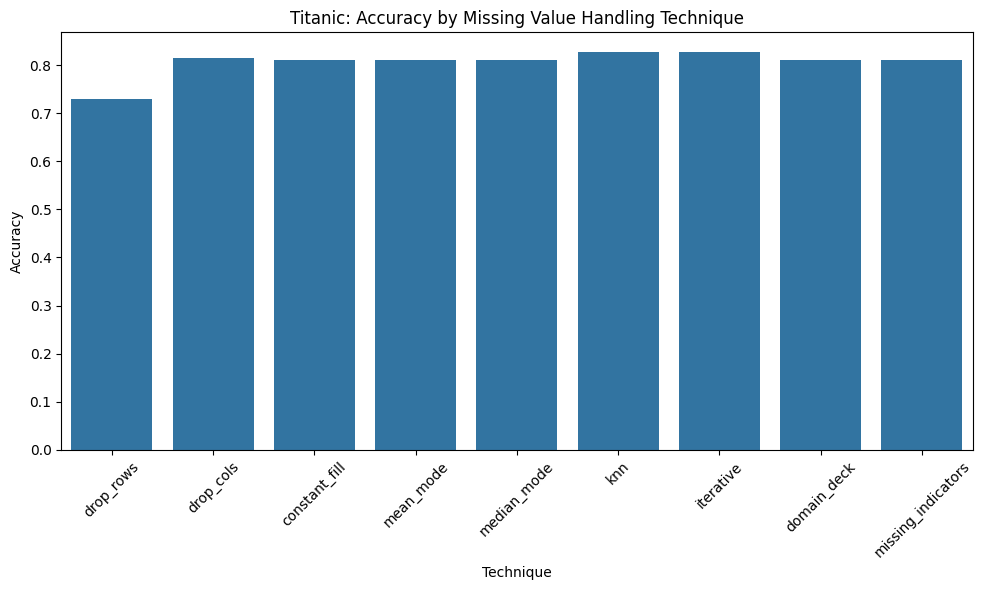

In [31]:


plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x="Technique", y="Accuracy")
plt.xticks(rotation=45)
plt.title("Titanic: Accuracy by Missing Value Handling Technique")
plt.tight_layout()
plt.show()